In [ ]:
!pip install pandas scikit-learn nltk


In [ ]:

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list


ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                        Student Performance Factors                          94KB  2024-09-02 10:53:57          25673        453  1.0              
ironwolf404/electric-vehicle-population-in-usa                 Electric Vehicle Population in USA                    6MB  2024-10-05 12:06:02            752         25  1.0              
abdulszz/spotify-most-streamed-songs                           Spotify Most Streamed Songs                          60KB  2024-09-07 18:23:14           9357        124  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset    Mo

In [ ]:

!kaggle datasets download -d pypiahmad/goodreads-book-reviews
!unzip goodreads-book-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/pypiahmad/goodreads-book-reviews
License(s): apache-2.0
100% 6.31G/6.31G [00:49<00:00, 112MB/s]
100% 6.31G/6.31G [00:49<00:00, 137MB/s]
Archive:  goodreads-book-reviews.zip
  inflating: goodreads_reviews_dedup.json  
  inflating: goodreads_reviews_spoiler.json  
  inflating: goodreads_reviews_spoiler_raw.json  


In [ ]:
import pandas as pd
df = pd.read_json('goodreads_reviews_spoiler.json', lines = True)
df.head()
df.columns

Index(['user_id', 'timestamp', 'review_sentences', 'rating', 'has_spoiler',
       'book_id', 'review_id'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378033 entries, 0 to 1378032
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1378033 non-null  object        
 1   timestamp         1378033 non-null  datetime64[ns]
 2   review_sentences  1378033 non-null  object        
 3   rating            1378033 non-null  int64         
 4   has_spoiler       1378033 non-null  bool          
 5   book_id           1378033 non-null  int64         
 6   review_id         1378033 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(2), object(3)
memory usage: 64.4+ MB


In [ ]:
df['has_spoiler'].value_counts()

,count
has_spoiler,
False,1288406
True,89627


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def clean_text(sentences):
    cleaned_sentences = []
    for sentence in sentences:
        if isinstance(sentence, str):
            sentence = re.sub(r'[^\w\s]', '', sentence)
            sentence = sentence.lower()
            sentence = ' '.join([word for word in sentence.split() if word not in stopwords.words('english')])
        cleaned_sentences.append(sentence)
    return cleaned_sentences

df['cleaned_text'] = df['review_sentences'].apply(clean_text)
df['cleaned_text'].fillna('', inplace=True)

X_train = df['cleaned_text'].astype(str).tolist()
X_test = df['cleaned_text'].astype(str).tolist()

# Recheck for empty documents again
empty_docs_train = [doc for doc in X_train if len(doc.strip()) == 0]
empty_docs_test = [doc for doc in X_test if len(doc.strip()) == 0]

print(f"Number of empty documents in training set after cleaning: {len(empty_docs_train)}")
print(f"Number of empty documents in testing set after cleaning: {len(empty_docs_test)}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-11-c584072d1c11>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cleaned_text'].fillna('', inplace=True)


Number of empty documents in training set after cleaning: 0
Number of empty documents in testing set after cleaning: 0


In [ ]:
from sklearn.model_selection import train_test_split
X = df['cleaned_text']
Y = df['has_spoiler']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Training data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")

Training data size: 1102426
Testing data size: 275607


In [ ]:
sample_size = 10
sample_data = df[['review_sentences', 'cleaned_text']].sample(n=sample_size, random_state=42)

print(sample_data)


                                          review_sentences  \
147051   [[0, Not sure I'm going to write a full review...   
1322675  [[0, Hooray this book is finally out!], [0, An...   
1221889  [[0, I think I'm losing interest in NA.], [0, ...   
1008531  [[0, This book features Michael, the man who d...   
859048   [[0, As with the first book in the Kitty Norvi...   
399220   [[0, There were a few grammar and sentence lev...   
799969   [[0, Amazing urban fantasy.], [0, For once mag...   
993745   [[0, Think this would have been perfect just h...   
1188494  [[0, I liked Angel Fire more than Angel - whic...   
1305916  [[0, Overall a good read!], [0, A little slow ...   

                                              cleaned_text  
147051   [[0, Not sure I'm going to write a full review...  
1322675  [[0, Hooray this book is finally out!], [0, An...  
1221889  [[0, I think I'm losing interest in NA.], [0, ...  
1008531  [[0, This book features Michael, the man who d...  
859048   [[0

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Recursive function to flatten nested lists
def flatten_text(doc):
    if isinstance(doc, list):
        return ' '.join(flatten_text(subdoc) for subdoc in doc)  # Recursively flatten sub-lists
    else:
        return str(doc)  # Ensure that the items are strings

# Apply the function to both train and test datasets
X_train_str = [flatten_text(doc) for doc in X_train]
X_test_str = [flatten_text(doc) for doc in X_test]

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)

# Transform the train and test datasets
X_train_tfidf = vectorizer.fit_transform(X_train_str)
X_test_tfidf = vectorizer.transform(X_test_str)

# Proceed with model training and evaluation


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=100, verbose=1)
model.fit(X_train_tfidf, Y_train)

X_test_tfidf = vectorizer.transform(X_test)
y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


AttributeError: 'list' object has no attribute 'lower'

In [ ]:
pip install matplotlib numpy


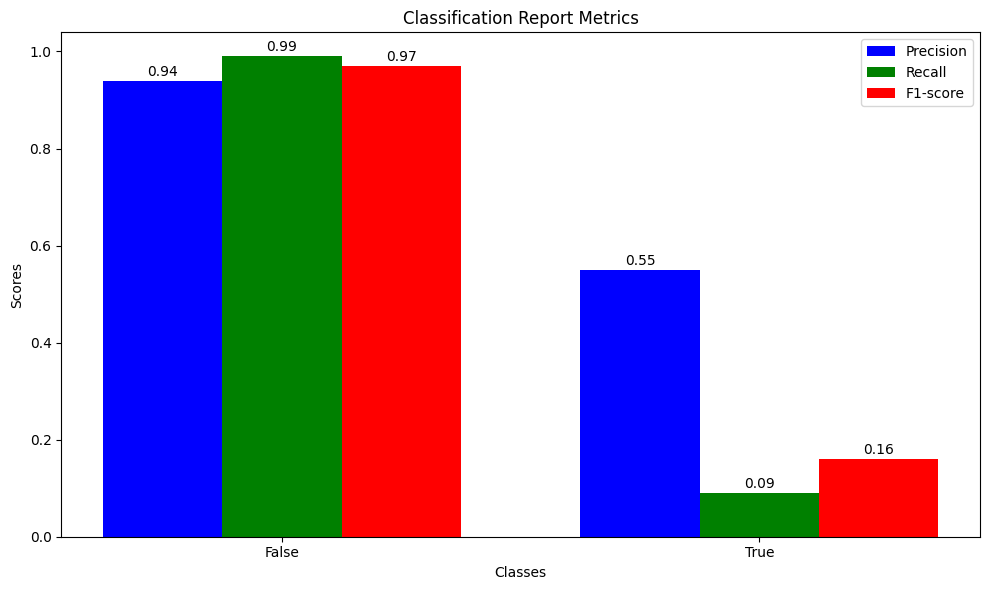

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the classification report
classes = ['False', 'True']
precision = [0.94, 0.55]
recall = [0.99, 0.09]
f1_score = [0.97, 0.16]

# Creating a bar chart for precision, recall, and F1-score
bar_width = 0.25
x = np.arange(len(classes))

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bars for each metric
bars1 = ax.bar(x - bar_width, precision, bar_width, label='Precision', color='b')
bars2 = ax.bar(x, recall, bar_width, label='Recall', color='g')
bars3 = ax.bar(x + bar_width, f1_score, bar_width, label='F1-score', color='r')

# Adding labels, title, and legend
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Adding value annotations on the bars
for bar in bars1 + bars2 + bars3:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center')

plt.tight_layout()
plt.show()



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_model = SVC(kernel = 'linear', verbose = 1);
svm_model.fit(X_train_tfidf, Y_train);

y_pred_svm = svm_model.predict(X_test_tfidf)

accuracy_svm = accuracy_score(Y_test, y_pred_svm)
report_svm = classification_report(Y_test, y_pred_svm)

print(f"Accuracy (SVM): {accuracy_svm}")
print("Classification Report (SVM):")
print(report_svm)
